In [59]:
#@title
# Device info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 13 21:49:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    38W / 250W |   1085MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup

In [60]:
!git clone https://github.com/dimitreOliveira/cryptogans.git

fatal: destination path 'cryptogans' already exists and is not an empty directory.


In [61]:
!pip install -qq tensorflow-addons

# Dependencies

In [62]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

# Auxiliary functions

In [63]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    image = ((image + 1) / 2) # scale back
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
  plt.show()

def decode_img(inputs):
    file_path = inputs["paths"]
    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, channels=img_shape[2])
    img = tf.image.resize(img, img_shape[:2])
    return img

def get_dataset(inputs, batch_size=32):
    if type(inputs) == dict:
        dataset = tf.data.Dataset.from_tensor_slices(inputs) # load from paths
    else:
        filepaths = glob.glob(f"{inputs}/*") # get images paths
        dataset = tf.data.Dataset.list_files(filepaths) # load directly from images
    
    dataset = (dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)                      
                      .shuffle(1024)
                      # .batch(batch_size, drop_remainder=True)
                      # .map(preprocess_model, num_parallel_calls=tf.data.AUTOTUNE)
                      # .prefetch(tf.data.AUTOTUNE)
              )
    return dataset

In [64]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(images, batch_size, codings_size):
  noise = tf.random.normal([batch_size, codings_size])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # gen_loss = generator_loss(fake_output)
    gen_loss = (generator_loss(fake_output) + 
                tf.reduce_mean(fake_output[:, -1]) # constrain alpha channel
                )
    disc_loss = discriminator_loss(real_output, fake_output)

  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

def train(dataset, epochs, batch_size, codings_size):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch, batch_size, codings_size)

    print(f"Epoch {epoch+1}/{epochs}")
    # Generate after the final epoch
    noise = tf.random.normal([batch_size, codings_size])
    display_images = generator(noise, training=False)
    plot_multiple_images(display_images, 8)

In [65]:
class Preprocess(tf.keras.layers.Layer):
    def __init__(self):
        super(Preprocess, self).__init__()

    def call(self, inputs):
        return (inputs / 255.) * 2 - 1

class Postprocess(tf.keras.layers.Layer):
    def __init__(self):
        super(Postprocess, self).__init__()

    def call(self, inputs):
        return ((inputs + 1) / 2)

def preprocess_fn():
    inputs = tf.keras.layers.Input(shape=(img_shape), dtype=tf.float32, name='inputs')
    outputs = Preprocess()(inputs)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="preprocess")

def postprocess_fn():
    inputs = tf.keras.layers.Input(shape=(img_shape), dtype=tf.float32, name='inputs')
    outputs = Postprocess()(inputs)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="postprocess")

def inference_model_fn(generator, postprocess):
    x = generator.outputs
    outputs = postprocess(x)

    return tf.keras.models.Model(inputs=generator.inputs, outputs=outputs, name="inference_model")

In [66]:
def generator_fn():
    inputs = tf.keras.layers.Input(shape=(codings_size), dtype=tf.float32, name='inputs')
    x = tf.keras.layers.Dense(6 * 6 * 256, use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Reshape([6, 6, 256])(x)

    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding="same", 
                          use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", 
                          use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    outputs = tf.keras.layers.Conv2DTranspose(img_shape[2], kernel_size=5, strides=2, 
                                padding="same", activation="tanh", 
                                use_bias=False)(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="generator")

def discriminator_fn():
    inputs = tf.keras.layers.Input(shape=(img_shape), dtype=tf.float32, name='inputs')
    x = tfa.layers.SpectralNormalization(tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same", 
                          activation=tf.keras.layers.LeakyReLU(0.2)))(inputs)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tfa.layers.SpectralNormalization(tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same", 
                          activation=tf.keras.layers.LeakyReLU(0.2)))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tfa.layers.SpectralNormalization(tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same", 
                          activation=tf.keras.layers.LeakyReLU(0.2)))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(1, activation="sigmoid"))(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="discriminator")

# Parameters

In [67]:
base_path = "./cryptogans/data/"
images_path = f"{base_path}images/"
attributes_path = f"{base_path}attributes.csv"
img_shape = (24, 24, 4)
codings_size = 100
batch_size = 16
epochs = 200

# Preprocessing model

In [68]:
preprocess_model = preprocess_fn()
preprocess_model.summary()

Model: "preprocess"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 24, 4)]       0         
                                                                 
 preprocess_3 (Preprocess)   (None, 24, 24, 4)         0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


# Dataset

In [69]:
df = pd.read_csv(attributes_path)
df.id = df.id.apply(lambda x: f"{images_path}punk{x:03d}.png")
df.columns = [c.strip() for c in df.columns]
display(df.head())

,id,type,gender,skin tone,count,accessories
0,./cryptogans/data/images/punk000.png,Human,Female,Medium,3,Green Eye Shadow / Earring / Blonde Bob
1,./cryptogans/data/images/punk001.png,Human,Male,Dark,2,Smile / Mohawk
2,./cryptogans/data/images/punk002.png,Human,Female,Light,1,Wild Hair
3,./cryptogans/data/images/punk003.png,Human,Male,Dark,3,Wild Hair / Nerd Glasses / Pipe
4,./cryptogans/data/images/punk004.png,Human,Male,Medium,4,Big Shades / Wild Hair / Earring / Goat


In [70]:
# slice_cols = ['type', 'skin tone', 'count']
# slices_ds = {col:df[col].unique() for col in slice_cols}
# sampling_ds = []
# for k, values in slices_ds.items():
#   for value in values:
#     sampling_ds.append(get_dataset({"paths": df[df[k] == value].id}, batch_size=batch_size))

# sampling_ds = [get_dataset({"paths": df.id}, batch_size=batch_size)]
dataset = (get_dataset({"paths": df.id}, batch_size=batch_size)
                          .batch(batch_size)
                          .map(preprocess_model, num_parallel_calls=tf.data.AUTOTUNE)
                          .prefetch(tf.data.AUTOTUNE))

# Model

## Generator

In [71]:
generator = generator_fn()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 9216)              921600    
                                                                 
 batch_normalization_9 (Batc  (None, 9216)             36864     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 9216)              0         
                                                                 
 reshape_3 (Reshape)         (None, 6, 6, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 6, 6, 128)        819200    
 ranspose)                                               

## Discriminator

In [72]:
discriminator = discriminator_fn()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 24, 4)]       0         
                                                                 
 spectral_normalization_12 (  (None, 12, 12, 64)       4224      
 SpectralNormalization)                                          
                                                                 
 dropout_9 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 spectral_normalization_13 (  (None, 6, 6, 128)        131328    
 SpectralNormalization)                                          
                                                                 
 dropout_10 (Dropout)        (None, 6, 6, 128)         0         
                                                                 
 spectral_normalization_14 (  (None, 3, 3, 256)      

In [73]:
gen_optimizer = tf.keras.optimizers.RMSprop()
disc_optimizer = tf.keras.optimizers.RMSprop()
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Training

In [74]:
train(dataset, epochs, batch_size, codings_size)

Output hidden; open in https://colab.research.google.com to view.

# Push model to HuggingFacce hub

In [75]:
# !pip install -qq git+https://github.com/LysandreJik/huggingface_hub@auto-track-binary-files
# !sudo apt-get -qq install git-lfs

In [76]:
# from huggingface_hub import notebook_login, push_to_hub_keras, from_pretrained_keras

In [77]:
postprocess_model = postprocess_fn()
inference_model = inference_model_fn(generator, postprocess_model)

In [78]:
# notebook_login()

In [79]:
# project_name = "crypto-gan"
# organization = "huggan"

# push_to_hub_keras(inference_model, 
#                   repo_path_or_name=project_name, 
#                   organization=organization)

# Test model

## Load model

In [80]:
# hub_generator = from_pretrained_keras(f"{organization}/{project_name}")
hub_generator = inference_model
hub_generator.summary()

Model: "inference_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 9216)              921600    
                                                                 
 batch_normalization_9 (Batc  (None, 9216)             36864     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 9216)              0         
                                                                 
 reshape_3 (Reshape)         (None, 6, 6, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 6, 6, 128)        819200    
 ranspose)                                         

## Generate samples

In [81]:
def generate(generator, seed):
    noise = tf.random.normal(shape=[n_images, codings_size], seed=seed)
    generated_images = generator(noise, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(6, 6, i+1)
        plt.imshow(generated_images[i, :, :, :])
        plt.axis('off')
    plt.show( )# return fig

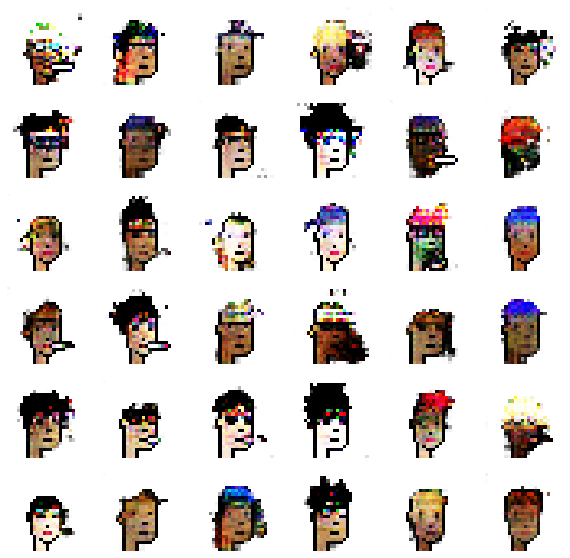

In [82]:
n_images = 36
codings_size = 100

generate(hub_generator, 22)